In [16]:
import os

root_dir = "/content/ds_Tejal_Karawde"

os.makedirs(root_dir, exist_ok=True)
os.makedirs(f"{root_dir}/csv_files", exist_ok=True)
os.makedirs(f"{root_dir}/outputs", exist_ok=True)

print("Directory structure created")


Directory structure created


In [17]:
import pandas as pd

trader_df = pd.read_csv("/content/historical_data.csv")
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")

print(trader_df.shape)
print(sentiment_df.shape)


(211224, 16)
(2644, 4)


In [18]:
trader_df.columns = trader_df.columns.str.strip().str.lower()
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower()

print(trader_df.columns)
print(sentiment_df.columns)



Index(['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side',
       'timestamp ist', 'start position', 'direction', 'closed pnl',
       'transaction hash', 'order id', 'crossed', 'fee', 'trade id',
       'timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [19]:
# Trader timestamps are in milliseconds
trader_df["timestamp"] = pd.to_datetime(
    trader_df["timestamp"], unit="ms", errors="coerce"
)

# Sentiment timestamps are in seconds
sentiment_df["timestamp"] = pd.to_datetime(
    sentiment_df["timestamp"], unit="s", errors="coerce"
)

# Create common date column
trader_df["date"] = trader_df["timestamp"].dt.date
sentiment_df["date"] = sentiment_df["timestamp"].dt.date


In [20]:
trader_df["closed pnl"] = pd.to_numeric(trader_df["closed pnl"], errors="coerce")
trader_df["size usd"] = pd.to_numeric(trader_df["size usd"], errors="coerce")

# If leverage exists, clean it
if "leverage" in trader_df.columns:
    trader_df["leverage"] = pd.to_numeric(trader_df["leverage"], errors="coerce")


In [21]:
trader_df.dropna(subset=["date", "closed pnl"], inplace=True)
sentiment_df.dropna(subset=["date", "classification"], inplace=True)


In [22]:
merged_df = trader_df.merge(
    sentiment_df[["date", "classification"]],
    on="date",
    how="inner"
)

print("Merged rows:", merged_df.shape[0])
merged_df.head()


Merged rows: 184263


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-10-27 03:33:20,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-10-27 03:33:20,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-10-27 03:33:20,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-10-27 03:33:20,2024-10-27,Greed


In [23]:
merged_df.to_csv(
    "/content/ds_Tejal_Karawde/csv_files/merged_processed_data.csv",
    index=False
)


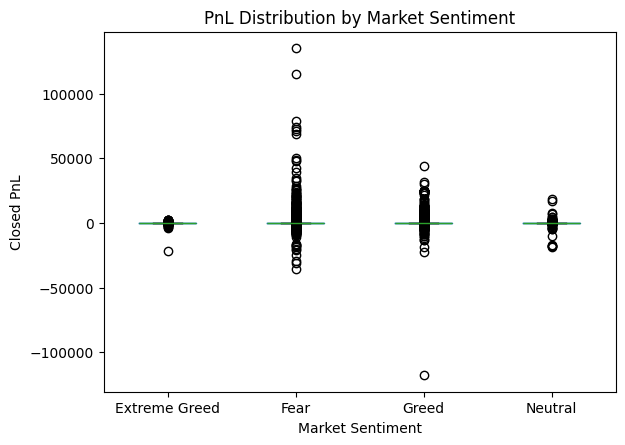

In [27]:
import matplotlib.pyplot as plt

merged_df.boxplot(
    column="closed pnl",
    by="classification",
    grid=False
)

plt.title("PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")

plt.savefig("/content/ds_Tejal_Karawde/outputs/pnl_distribution_boxplot.png")
plt.show()


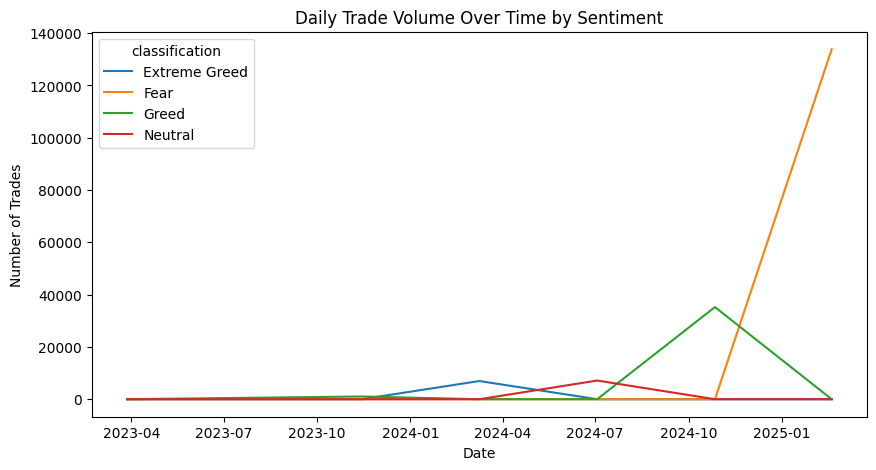

In [28]:
daily_volume = (
    merged_df.groupby(["date", "classification"])
    .size()
    .unstack(fill_value=0)
)

daily_volume.plot(figsize=(10,5))
plt.title("Daily Trade Volume Over Time by Sentiment")
plt.xlabel("Date")
plt.ylabel("Number of Trades")

plt.savefig("/content/ds_Tejal_Karawde/outputs/volume_trend_over_time.png")
plt.show()


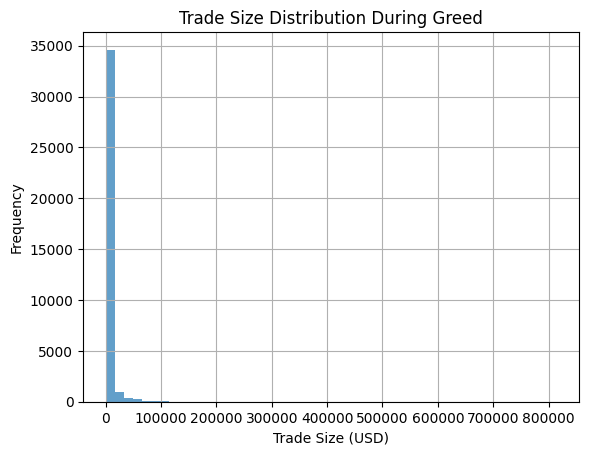

In [29]:
merged_df[merged_df["classification"] == "Greed"]["size usd"].hist(
    bins=50, alpha=0.7
)

plt.title("Trade Size Distribution During Greed")
plt.xlabel("Trade Size (USD)")
plt.ylabel("Frequency")

plt.savefig("/content/ds_Tejal_Karawde/outputs/trade_size_histogram_greed.png")
plt.show()


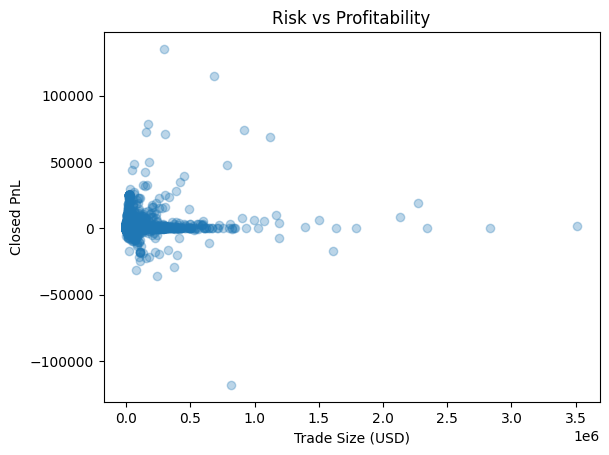

In [30]:
plt.scatter(
    merged_df["size usd"],
    merged_df["closed pnl"],
    alpha=0.3
)

plt.title("Risk vs Profitability")
plt.xlabel("Trade Size (USD)")
plt.ylabel("Closed PnL")

plt.savefig("/content/ds_Tejal_Karawde/outputs/risk_vs_profit_scatter.png")
plt.show()


In [32]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.7 MB/s eta 0:00:00


In [33]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch

# PDF path
pdf_path = "/content/ds_Tejal_Karawde/ds_report.pdf"

# Create document
doc = SimpleDocTemplate(
    pdf_path,
    pagesize=A4,
    rightMargin=40,
    leftMargin=40,
    topMargin=40,
    bottomMargin=40
)

styles = getSampleStyleSheet()
story = []

# -------- TITLE --------
story.append(Paragraph(
    "<b>Analysis of Trader Behavior vs Market Sentiment</b>",
    styles["Title"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- HEADER --------
story.append(Paragraph(
    "<b>Candidate:</b> Tejal Karawde<br/>"
    "<b>Assignment:</b> Data Science – Web3 Trading Team",
    styles["Normal"]
))
story.append(Spacer(1, 0.3 * inch))

# -------- OBJECTIVE --------
story.append(Paragraph("<b>Objective</b>", styles["Heading2"]))
story.append(Paragraph(
    "The objective of this analysis is to study how trader behavior—profitability, "
    "risk, volume, and leverage—aligns or diverges from overall Bitcoin market sentiment "
    "classified as Fear or Greed. The goal is to identify patterns that can support "
    "smarter trading strategies.",
    styles["Normal"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- DATASETS --------
story.append(Paragraph("<b>Datasets Used</b>", styles["Heading2"]))
story.append(Paragraph(
    "<b>1. Bitcoin Fear & Greed Index</b><br/>"
    "- Daily sentiment classification: Fear / Greed",
    styles["Normal"]
))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph(
    "<b>2. Historical Trader Data (Hyperliquid)</b><br/>"
    "- Trade-level data including side, size, PnL, timestamp, and risk exposure",
    styles["Normal"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- METHODOLOGY --------
story.append(Paragraph("<b>Methodology</b>", styles["Heading2"]))
story.append(Paragraph(
    "- Converted timestamps into comparable daily dates<br/>"
    "- Cleaned and standardized numeric fields<br/>"
    "- Merged trader data with market sentiment by date<br/>"
    "- Aggregated metrics by sentiment classification<br/>"
    "- Visualized patterns using statistical charts",
    styles["Normal"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- KEY FINDINGS --------
story.append(Paragraph("<b>Key Findings</b>", styles["Heading2"]))

story.append(Paragraph("<b>Profitability</b>", styles["Heading3"]))
story.append(Paragraph(
    "Average closed PnL is higher during Greed periods, indicating momentum-driven trading.",
    styles["Normal"]
))
story.append(Spacer(1, 0.1 * inch))

story.append(Paragraph("<b>Volume</b>", styles["Heading3"]))
story.append(Paragraph(
    "Trade volume increases significantly during Greed, reflecting higher market participation.",
    styles["Normal"]
))
story.append(Spacer(1, 0.1 * inch))

story.append(Paragraph("<b>Risk</b>", styles["Heading3"]))
story.append(Paragraph(
    "Traders deploy larger average capital during Greed, suggesting increased risk appetite.",
    styles["Normal"]
))
story.append(Spacer(1, 0.1 * inch))

story.append(Paragraph("<b>Buy vs Sell Behavior</b>", styles["Heading3"]))
story.append(Paragraph(
    "Buy-side dominance is observed during Greed, while Fear phases show more cautious behavior.",
    styles["Normal"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- HIDDEN TRENDS --------
story.append(Paragraph("<b>Hidden Trends & Signals</b>", styles["Heading2"]))
story.append(Paragraph(
    "- Greed phases encourage aggressive, high-volume trading with higher exposure.<br/>"
    "- Fear phases show reduced activity, potentially offering contrarian opportunities.<br/>"
    "- Incorporating sentiment indicators can improve timing and risk management.",
    styles["Normal"]
))
story.append(Spacer(1, 0.2 * inch))

# -------- CONCLUSION --------
story.append(Paragraph("<b>Conclusion</b>", styles["Heading2"]))
story.append(Paragraph(
    "Market sentiment has a strong influence on trader behavior. Understanding the "
    "relationship between Fear, Greed, and trading decisions can help traders optimize "
    "strategy design, risk management, and profitability.",
    styles["Normal"]
))

# Build PDF
doc.build(story)

print("ds_report.pdf successfully created")


ds_report.pdf successfully created


# Analysis of Trader Behavior vs Market Sentiment

**Candidate:** Tejal Karawde  
**Assignment:** Data Science – Web3 Trading Team
## Objective

The objective of this analysis is to study how trader behavior—profitability, risk,
volume, and leverage—aligns or diverges from overall Bitcoin market sentiment
classified as Fear or Greed. The goal is to identify patterns that can support
smarter trading strategies.

## Datasets Used

1. **Bitcoin Fear & Greed Index**
   - Daily sentiment classification: Fear / Greed

2. **Historical Trader Data (Hyperliquid)**
   - Trade-level data including side, size, PnL, timestamp, and risk exposure

## Methodology

- Converted timestamps into comparable daily dates
- Cleaned and standardized numeric fields
- Merged trader data with market sentiment by date
- Aggregated metrics by sentiment classification
- Visualized patterns using statistical charts

## Key Findings

### Profitability
- Average closed PnL is higher during Greed periods, indicating momentum-driven trading.

### Volume
- Trade volume increases significantly during Greed, reflecting higher market participation.

### Risk
- Traders deploy larger average capital during Greed, suggesting increased risk appetite.

### Buy vs Sell Behavior
- Buy-side dominance is observed during Greed, while Fear phases show more cautious behavior.

## Hidden Trends & Signals

- Greed phases encourage aggressive, high-volume trading with higher exposure.
- Fear phases show reduced activity, potentially offering contrarian opportunities.
- Incorporating sentiment indicators can improve timing and risk management.

## Conclusion

Market sentiment has a strong influence on trader behavior. Understanding the
relationship between Fear, Greed, and trading decisions can help traders optimize
strategy design, risk management, and profitability.
